To install: 
<pre>
pip install rdkit useful_rdkit_utils lightgbm scikit-learn pingouin scipy matplotlib numpy 
</pre>

In [1]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit.Chem import rdFingerprintGenerator
from sklearn.metrics import r2_score, mean_absolute_error
from rdkit import Chem
from lightgbm import LGBMRegressor
from sort_and_slice_ecfp_featuriser import create_sort_and_slice_ecfp_featuriser
from scipy.stats import ttest_ind
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def gen_LGBMRegressor():
    return LGBMRegressor()

def calc_morgan_count_fps(fp_name, train, test): 
    train['mol'] = train.SMILES.apply(Chem.MolFromSmiles)
    test['mol'] = test.SMILES.apply(Chem.MolFromSmiles)
    fg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
    train[fp_name] = train.mol.apply(fg.GetCountFingerprintAsNumPy)
    test[fp_name] = test.mol.apply(fg.GetCountFingerprintAsNumPy)

def calc_sort_and_slice_fps(fp_name, train, test):
    train['mol'] = train.SMILES.apply(Chem.MolFromSmiles)
    test['mol'] = test.SMILES.apply(Chem.MolFromSmiles)
    featurizer = create_sort_and_slice_ecfp_featuriser(train.mol,print_train_set_info=False)
    train[fp_name] = [featurizer(x) for x in train.mol]
    test[fp_name] = [featurizer(x) for x in test.mol]
    
def cohen_d(s1,s2):
    s1 = s1.values
    s2 = s2.values
    return np.abs(np.mean(s1-s2)/np.std(s1-s2))

def make_paired_plots(result_df):
    result_df["idx"] = range(0,len(result_df))
    id_vars = ["idx","group","fold","model","desc"]    
    melt_df = result_df.drop("MAE",axis=1).query("group == 'butina' and model == 'LGBM'").melt(id_vars=id_vars)
    figure, axes = plt.subplots(1,2)
    ax_1 = pg.plot_paired(melt_df, dv="value",subject="fold",within="desc",ax=axes[0])
    ax_1.set_xlabel("Method")
    ax_1.set_ylabel("$R^2$")
    ax_1.set_title("$R^2$")
    melt_df = result_df.drop("R2",axis=1).query("group == 'butina' and model == 'LGBM'").melt(id_vars=id_vars)
    ax_2 = pg.plot_paired(melt_df, dv="value",subject="fold",within="desc")
    ax_2.set_xlabel("Method")
    ax_2.set_ylabel("MAE")
    ax_2.set_title("MAE");    
    
def color_p_value(val):
    color = 'lightgreen' if float(val) < 0.05 else 'pink'
    return 'background-color: %s' % color

def color_cohens_d(val):
    color = 'pink'
    if val > 0.5 and val < 0.8:
        color = 'yellow'
    elif val > 0.8:
        color = 'lightgreen'
    return 'background-color: %s' % color

def generate_stats_table(result_df):
    morgan = result_df.query("desc == 'morgan_counts'")
    sort_slice = result_df.query("desc == 'sort_and_slice'")
    p_r2, p_mae = ttest_ind(morgan.R2, sort_slice.R2).pvalue,ttest_ind(morgan.MAE, sort_slice.MAE).pvalue
    d_r2, d_mae = cohen_d(morgan.R2,sort_slice.R2),cohen_d(morgan.MAE, sort_slice.MAE)
    out_df = pd.DataFrame([["R2",p_r2,d_r2],["MAE",p_mae,d_mae]],columns=["Metric","p","d"]).round(2)
    return out_df.style.map(color_p_value, subset=['p']).map(color_cohens_d, subset=['d']).format(precision=2)

Read the data from [Fang et al](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.3c00160) this data was copied from the file on the authors' [GitHub site](https://github.com/molecularinformatics/Computational-ADME)

In [3]:
df = pd.read_csv("data/ADME_public_set_3521.csv")

In [4]:
df

,Internal ID,Vendor ID,SMILES,CollectionName,LOG HLM_CLint (mL/min/kg),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG RLM_CLint (mL/min/kg)
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,0.675687,1.493167,0.089905,0.991226,0.518514,1.392169
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,0.675687,1.040780,0.550228,0.099681,0.268344,1.027920
2,Mol3,304005766,CN(c1ncc(F)cn1)[C@H]1CCCNC1,emolecules,0.675687,-0.358806,NaN,2.000000,2.000000,1.027920
3,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,0.675687,1.026662,1.657056,-1.158015,-1.403403,1.027920
4,Mol5,324059015,CC(C)(O)CCn1cc2cc(NC(=O)c3cccc(C(F)(F)F)n3)c(C...,emolecules,0.996380,1.010597,NaN,1.015611,1.092264,1.629093
...,...,...,...,...,...,...,...,...,...,...
3516,Mol3517,43258693,O=C(c1ccc2c(c1)CCCC2)N1CCOCC1c1ccn[nH]1,emolecules,NaN,0.606813,NaN,NaN,NaN,NaN
3517,Mol3518,27448206,O=C(Nc1nc2ccccc2[nH]1)c1ccc(-n2cccc2)cc1,emolecules,NaN,-0.444495,NaN,NaN,NaN,NaN
3518,Mol3519,207150215,NC(=O)c1noc([C@@H](CCCC2CCCCC2)CC(=O)NO)n1,emolecules,0.863799,NaN,NaN,NaN,NaN,NaN
3519,Mol3520,25037224,CCCCCCCCc1ccc(CC[C@](N)(CO)COP(=O)(O)O)cc1,emolecules,0.881385,NaN,NaN,NaN,NaN,NaN


Reformat the data into individual files for analysis.  Create assay names that are more "machine friendly".

In [5]:
cols = list(df.columns[0:4])

In [6]:
name_list = [
    ['LOG HLM_CLint (mL/min/kg)','hlm_CLint'],
    ['LOG SOLUBILITY PH 6.8 (ug/mL)','logS'],
    ['LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)','h_ppb'],
    ['LOG PLASMA PROTEIN BINDING (RAT) (% unbound)','r_ppb'],
    ['LOG RLM_CLint (mL/min/kg)','rlm_CLint']
]

In [7]:
for name,alias in name_list:
    row_df = df[cols+[name]].dropna(subset=name).copy()
    row_df.rename({name : alias},axis=1,inplace=True)
    outname = f"data/biogen_{alias}.csv"
    row_df.to_csv(outname, index=False)

Setup a 5x5 cross validation experiment for the **cross_validation** method in [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils).  This is described in more detain in [this jupyter notebook](https://github.com/PatWalters/useful_rdkit_utils/blob/master/notebooks/demo_cross_validate.ipynb)

In [8]:
model_list = [["LGBM",gen_LGBMRegressor]]
descriptor_list = [["morgan_counts", calc_morgan_count_fps],["sort_and_slice",calc_sort_and_slice_fps]]
group_list = [["butina",uru.get_butina_clusters]]
metric_list = [["R2",r2_score],["MAE",mean_absolute_error]]

Run cross validation experiments with the five Biogen ADME datasets.

data/biogen_h_ppb.csv 194


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,Metric,p,d
0,R2,0.81,0.14
1,MAE,0.46,0.40


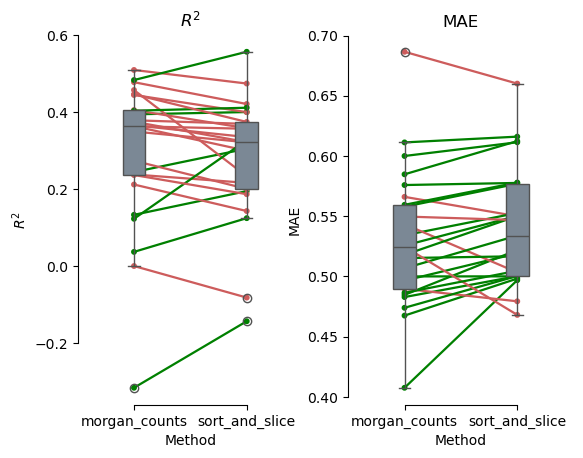

data/biogen_hlm_CLint.csv 3087


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,Metric,p,d
0,R2,0.00,2.39
1,MAE,0.00,2.69


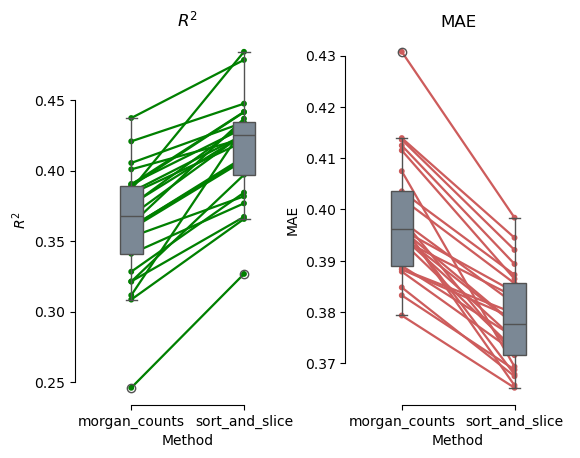

data/biogen_logS.csv 2173


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,Metric,p,d
0,R2,0.41,0.33
1,MAE,0.36,0.39


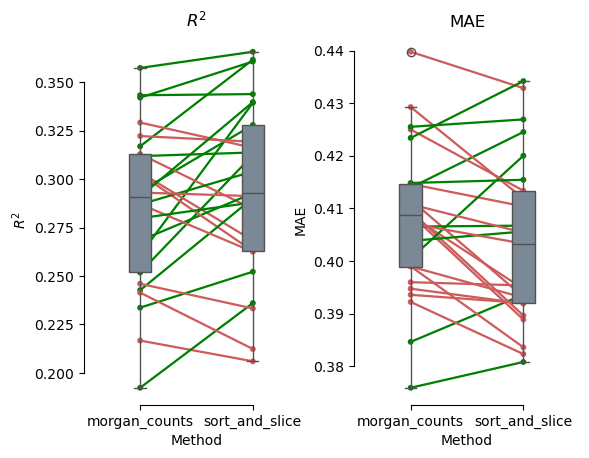

data/biogen_r_ppb.csv 168


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,Metric,p,d
0,R2,0.61,0.29
1,MAE,0.36,0.32


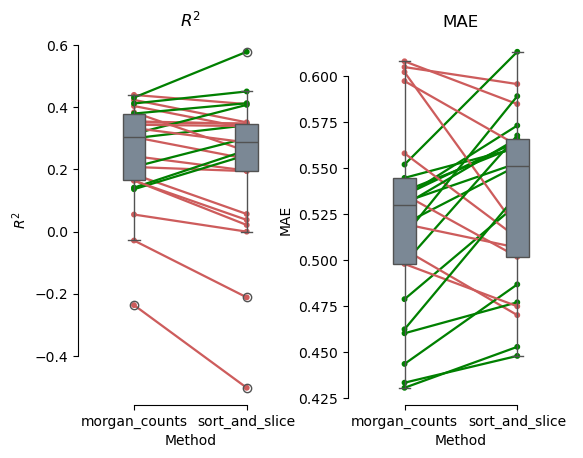

data/biogen_rlm_CLint.csv 3054


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,Metric,p,d
0,R2,0.00,2.62
1,MAE,0.00,2.63


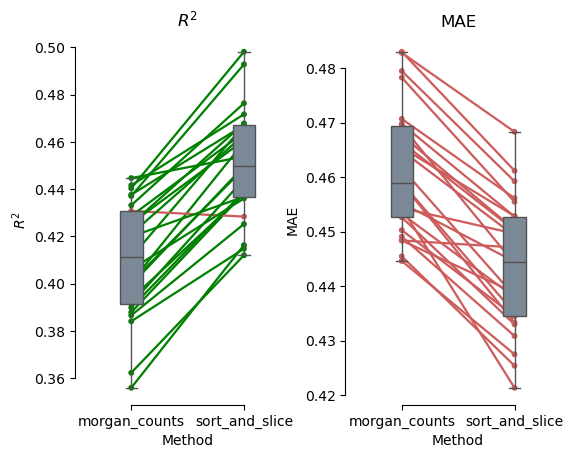

In [9]:
for file_name in sorted(glob("data/biogen*.csv")):
    y_column = file_name.replace("data/biogen_","").replace(".csv","")
    df = pd.read_csv(file_name)
    print(file_name,len(df))
    result_list = uru.cross_validate(df, model_list, y_column, descriptor_list, group_list, metric_list, 5, 5)
    result_df = pd.DataFrame(result_list)
    display(generate_stats_table(result_df))
    make_paired_plots(result_df)
    plt.show()